Prompt: 
> In this assignment, you will experiment with running a DNN and measuring its performance with Colab GPU & ThetaGPU.
> 
> We provide both Pytorch & TF2.0 snippets for you to start with. 
> 
> You should implement the JAX version using [haiku](https://github.com/deepmind/dm-haiku) or [flax](https://github.com/google/flax). Since JAX doesn't handle dataloading, you can use either pytorch loader or tensorflow loader.
> 
> * Based on assignment-1 notebook, adapted from ["PyTorch 1.2 Quickstart with Google Colab"](https://colab.research.google.com/github/omarsar/pytorch_notebooks/blob/master/pytorch_quick_start.ipynb) and ["Tensorflow 2.0 Quickstart for experts"](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=DUNzJc4jTj6G)



Notes:

- The main results for all 3 platforms (Torch, TF, Jax) on both Colab and ThetaGPU are documented on here. 
- But this notebook was run on Colab. For the one run on ThetaGPU, refer to the notebook at <https://github.com/tuanpham96/DeepLearningSystems-Fall2021/tree/main/HW4/HW4-thetagpu.ipynb>
- Repo: <https://github.com/tuanpham96/DeepLearningSystems-Fall2021/blob/main/HW4/>

# PyTorch version

## Installation

In [ ]:
!pip3 install torch torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

if torch.cuda.is_available():
    !nvidia-smi

1.9.0+cu111
Tue Oct 26 01:46:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                            

## Import The Data `torch.utils.data.Dataloader`
The first step before training the model is to import the data. We will use the [CIFAR100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) which is like the Hello World dataset of machine learning. 

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models. 
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. We encourage you to experiment with different batches.

In [ ]:
BATCH_SIZE = 32
EPOCHS = 15

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

## download and load training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2, pin_memory=True)

## download and load testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


## Exploring the Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])


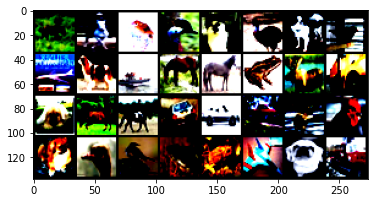

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(type(images))
## show images
imshow(torchvision.utils.make_grid(images))

## check dimensions of a batch
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

## The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. 

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `nn.Conv2d(...)`. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`. We hope to get a nice representation of this layer, so we use `out_channels=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d). 
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Notice for `d1` I have a dimension which looks like it came out of nowhere. 128 represents the size we want as output and the (`26*26*32`) represents the dimension of the incoming data. If you would like to find out how to calculate those numbers refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d). In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer. The same applies for the second linear transformation (`d2`) where the dimension of the output of the previous linear layer was added as `in_features=128`, and `10` is just the size of the output which also corresponds to the number of classes.
- After each one of those layers, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
model = LeNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training the model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

In [ ]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
%%time
from tqdm import tqdm

for epoch in tqdm(range(EPOCHS)):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for images, labels in trainloader:
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('\t Epoch: %d | Train Loss: %.4f | Train Accuracy: %.4f' \
          %(epoch, train_running_loss / len(trainloader), train_acc / len(trainloader)))

  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  7%|▋         | 1/15 [00:22<05:08, 22.06s/it]

Epoch: 0 | Train Loss: 1.5586 | Train Accuracy: 43.0942


 13%|█▎        | 2/15 [00:43<04:45, 21.96s/it]

Epoch: 1 | Train Loss: 1.2790 | Train Accuracy: 54.1107


 20%|██        | 3/15 [01:05<04:23, 21.96s/it]

Epoch: 2 | Train Loss: 1.1645 | Train Accuracy: 58.7332


 27%|██▋       | 4/15 [01:27<04:01, 21.95s/it]

Epoch: 3 | Train Loss: 1.0990 | Train Accuracy: 61.0885


 33%|███▎      | 5/15 [01:49<03:39, 21.95s/it]

Epoch: 4 | Train Loss: 1.0402 | Train Accuracy: 63.3157


 40%|████      | 6/15 [02:11<03:17, 21.96s/it]

Epoch: 5 | Train Loss: 1.0060 | Train Accuracy: 64.4354


 47%|████▋     | 7/15 [02:33<02:55, 21.93s/it]

Epoch: 6 | Train Loss: 0.9656 | Train Accuracy: 65.9449


 53%|█████▎    | 8/15 [02:55<02:33, 21.94s/it]

Epoch: 7 | Train Loss: 0.9409 | Train Accuracy: 66.6627


 60%|██████    | 9/15 [03:17<02:11, 21.88s/it]

Epoch: 8 | Train Loss: 0.9106 | Train Accuracy: 68.1262


 67%|██████▋   | 10/15 [03:39<01:49, 21.87s/it]

Epoch: 9 | Train Loss: 0.8874 | Train Accuracy: 68.4841


 73%|███████▎  | 11/15 [04:01<01:27, 21.87s/it]

Epoch: 10 | Train Loss: 0.8702 | Train Accuracy: 69.2318


 80%|████████  | 12/15 [04:22<01:05, 21.84s/it]

Epoch: 11 | Train Loss: 0.8516 | Train Accuracy: 69.9176


 87%|████████▋ | 13/15 [04:44<00:43, 21.81s/it]

Epoch: 12 | Train Loss: 0.8376 | Train Accuracy: 70.4714


 93%|█████████▎| 14/15 [05:06<00:21, 21.78s/it]

Epoch: 13 | Train Loss: 0.8261 | Train Accuracy: 71.0213


100%|██████████| 15/15 [05:28<00:00, 21.87s/it]

Epoch: 14 | Train Loss: 0.8107 | Train Accuracy: 71.3752
CPU times: user 3min 24s, sys: 18.1 s, total: 3min 42s
Wall time: 5min 28s


## Testing the model

In [ ]:
test_acc = 0.0

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        test_acc += get_accuracy(logits, labels, BATCH_SIZE)
print('Test Accuracy: %.4f'%(test_acc / len(testloader)))

Test Accuracy: 66.4836


## PyTorch benchmark performance

### Colab stats

- GPU model: `Tesla K80`
- Train Accuracy: **71.38 %** 
- Train Loss: **0.8107**
- Test Accuracy: **66.48 %** 
- How long did it take to train? 
    ```
    CPU times: user 3min 24s, sys: 18.1 s, total: 3min 42s
    Wall time: 5min 28s
    ```

### A100 - ThetaGPU stats
 
- Train Accuracy: **71.83 %** 
- Train Loss: **0.8072**
- Test Accuracy: **66.35 %** 
- How long did it take to train? 
    ```
    CPU times: user 1min 12s, sys: 8.03 s, total: 1min 20s
    Wall time: 1min 21s
    ```



So generally, the A100 on ThetaGPU is much faster (about 3-4x faster) than Colab. The performance is comparable between these two devices.

# Tensorflow 2 version

In [ ]:
!pip3 install tensorflow tensorflow-datasets==4.0.1 tensorflow_addons==0.14

     |████████████████████████████████| 1.1 MB 11.3 MB/s 


In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [ ]:
print(tf.__version__)

if tf.config.list_physical_devices('GPU'):
    !nvidia-smi

2.6.0
Tue Oct 26 01:52:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |    553MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

## Import The Data `tf.data.Dataset`
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning. 

Besides importing the data, we will also do a few more things:
- We will cast the data into float32 tensors
- We will use `tf.data.Dataset` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models. 
- similar to PyTorch, Tensorflow 2.0 Dataset API also provides convenient transformation and batching options, in a chaining style. We encourage you to experiment with different batches.

In [ ]:
import tensorflow.image as transforms

cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

Use `tf.data` to batch and shuffle the dataset:

In [ ]:
BATCH_SIZE = 32
EPOCHS = 15

def transform_train(image, label):
    image = transforms.resize(image, (32, 32))
    image = transforms.random_flip_left_right(image)
    image = transforms.per_image_standardization(image)
    return image, label

def transform(image, label):
    image = transforms.resize(image, (32, 32))
    image = transforms.per_image_standardization(image)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).map(transform_train).shuffle(10000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(transform).batch(BATCH_SIZE)


## Exploring the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image batch dimensions: (32, 32, 32, 3)
Image label dimensions: (32, 1)


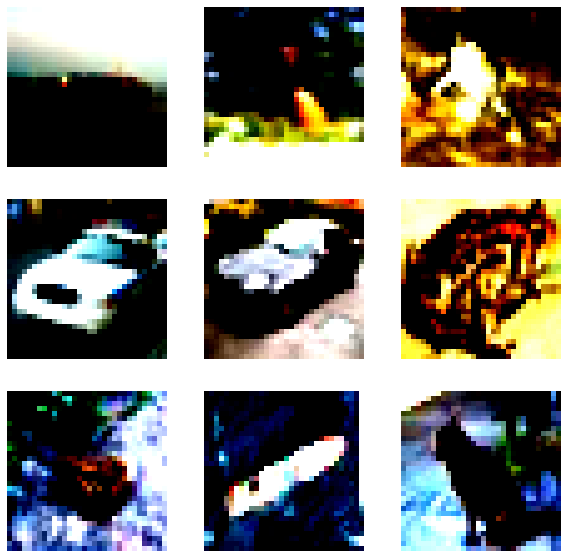

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze()) # https://stackoverflow.com/a/59601192
        plt.axis("off")

## check dimensions of a batch
for images, labels in train_ds:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

## The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. 

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing):
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `tf.keras.Conv2D(...)`. Keras infers the input dimension by itself, and we hope to get a nice representation of this layer, so we use `filters=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). 
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Keras infers the dimension of input by itself. For layer parameter math, please refer to the corresponding PyTorch block above and the [TF2 Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) for details. 
- Activation functions is configured within layer calls.

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D
from tensorflow.keras import Model

class LeNet(Model):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = Conv2D(6, 5, activation='relu')
        self.conv2 = Conv2D(16, 5, activation='relu')
        self.flatten = Flatten()
        self.maxpool = MaxPool2D((2,2), 2)
        self.fc1 = Dense(120, activation='relu')
        self.fc2 = Dense(84, activation='relu')
        self.fc3 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
# Create an instance of the model
model = LeNet()

## Training the model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

Choose an optimizer and loss function for training: 

In [ ]:
learning_rate = 0.001
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [ ]:
%%time 
from tqdm import tqdm

for epoch in tqdm(range(EPOCHS)):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    print('\t Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
        %(epoch, train_loss.result(), train_accuracy.result() * 100))

  7%|▋         | 1/15 [00:10<02:29, 10.65s/it]

	 Epoch: 0 | Loss: 1.5486 | Train Accuracy: 43.60


 13%|█▎        | 2/15 [00:21<02:18, 10.66s/it]

	 Epoch: 1 | Loss: 1.2727 | Train Accuracy: 54.80


 20%|██        | 3/15 [00:33<02:14, 11.23s/it]

	 Epoch: 2 | Loss: 1.1684 | Train Accuracy: 58.73


 27%|██▋       | 4/15 [00:45<02:06, 11.53s/it]

	 Epoch: 3 | Loss: 1.1060 | Train Accuracy: 61.04


 33%|███▎      | 5/15 [00:57<01:57, 11.78s/it]

	 Epoch: 4 | Loss: 1.0450 | Train Accuracy: 63.04


 40%|████      | 6/15 [01:09<01:47, 11.96s/it]

	 Epoch: 5 | Loss: 1.0036 | Train Accuracy: 64.73


 47%|████▋     | 7/15 [01:21<01:36, 12.03s/it]

	 Epoch: 6 | Loss: 0.9675 | Train Accuracy: 65.65


 53%|█████▎    | 8/15 [01:33<01:24, 12.04s/it]

	 Epoch: 7 | Loss: 0.9345 | Train Accuracy: 67.16


 60%|██████    | 9/15 [01:45<01:11, 11.99s/it]

	 Epoch: 8 | Loss: 0.9174 | Train Accuracy: 67.63


 67%|██████▋   | 10/15 [01:58<01:00, 12.07s/it]

	 Epoch: 9 | Loss: 0.8910 | Train Accuracy: 68.61


 73%|███████▎  | 11/15 [02:11<00:49, 12.35s/it]

	 Epoch: 10 | Loss: 0.8689 | Train Accuracy: 69.46


 80%|████████  | 12/15 [02:24<00:38, 12.72s/it]

	 Epoch: 11 | Loss: 0.8512 | Train Accuracy: 69.91


 87%|████████▋ | 13/15 [02:38<00:25, 12.95s/it]

	 Epoch: 12 | Loss: 0.8313 | Train Accuracy: 70.77


 93%|█████████▎| 14/15 [02:51<00:13, 13.05s/it]

	 Epoch: 13 | Loss: 0.8232 | Train Accuracy: 70.93


100%|██████████| 15/15 [03:04<00:00, 12.31s/it]

	 Epoch: 14 | Loss: 0.8030 | Train Accuracy: 71.68
CPU times: user 3min 33s, sys: 43.6 s, total: 4min 17s
Wall time: 3min 4s


## Testing the model

In [ ]:
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [ ]:
for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

print(f'Test Accuracy: {test_accuracy.result() * 100:.2f}')

Test Accuracy: 64.59


## Tensorflow benchmark performance

### Colab stats

- GPU model: `Tesla K80`
- Train Accuracy: **71.68 %** 
- Train Loss: **0.8030**
- Test Accuracy: **64.59 %** 
- How long did it take to train? 
    ```
    CPU times: user 3min 33s, sys: 43.6 s, total: 4min 17s
    Wall time: 3min 4s
    ```

### A100 - ThetaGPU stats
 
- Train Accuracy: **74.11 %** 
- Train Loss: **0.7392**
- Test Accuracy: **67.41 %** 
- How long did it take to train? 
    ```
    CPU times: user 1min 27s, sys: 7.95 s, total: 1min 35s
    Wall time: 1min 16s
    ```


So generally, the A100 on ThetaGPU is much faster (about 2-3x faster) than Colab for TensorFlow implementation. And although on Colab, TF is around 1.5-2x much faster than Torch, on A100, the former is only a few seconds (< 10s) faster than the latter. 

The performance is comparable, though A100 performs better than Colab on all accounts for TF. These results are also comparable to Torch implementation.

# JAX version
Use [haiku](https://github.com/deepmind/dm-haiku) or [flax](https://github.com/google/flax) as the high level interface for JAX neural network implementation.

## Installation

The installation in Colab (see below) is a little bit different for the one in ThetaGPU, see [thetagpu-notebook](https://github.com/tuanpham96/DeepLearningSystems-Fall2021/tree/main/HW4/HW4-thetagpu.ipynb) for the details.

In [ ]:
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html


In [ ]:
!pip install git+https://github.com/deepmind/dm-haiku
!pip install optax

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-7p2o0kkk
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-7p2o0kkk


## Import The Data
Jax doesn't handle data loading, you can use Pytorch, Tensorflow dataset or devise your own loader.

In [ ]:
BATCH_SIZE = 32
EPOCHS = 15
LR = 1e-3

In [ ]:
import tensorflow as tf
import tensorflow.image as transforms
import tensorflow_datasets as tfds 
import numpy as np


cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

def transform_train(image, label):
    image = transforms.resize(image, (32, 32))
    image = transforms.random_flip_left_right(image)
    image = transforms.per_image_standardization(image)
    return image, label

def transform(image, label):
    image = transforms.resize(image, (32, 32))
    image = transforms.per_image_standardization(image)
    return image, label

def load_dataset(is_training: bool, batch_size: int):
    if is_training:
        ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(transform_train).shuffle(10000)
    else:
        ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(transform)
    ds = ds.batch(batch_size)
    return tfds.as_numpy(ds)

train_ds = load_dataset(is_training = True, batch_size = BATCH_SIZE)
test_ds = load_dataset(is_training = False, batch_size = BATCH_SIZE)


170508288/170498071 [==============================] - 11s 0us/step


In [ ]:
import jax.numpy as jnp
print(jnp.ones(3).device_buffer.device())  

gpu:0


## The Model

In [ ]:
import jax
import jax.numpy as jnp
import haiku as hk
import optax

def lenet(images):
    net = hk.Sequential([
      hk.Conv2D(6,5), jax.nn.relu,
      hk.MaxPool((2,2),2,'VALID'),
      hk.Conv2D(16,5), jax.nn.relu,
      hk.MaxPool((2,2),2,'VALID'),
      hk.Flatten(),
      hk.Linear(120), jax.nn.relu,
      hk.Linear(84), jax.nn.relu,
      hk.Linear(10),
    ])
    return net(images)

@jax.jit
def accuracy(params, images, labels):
    predictions = net.apply(params, images)
    return jnp.mean(jnp.argmax(predictions, axis=-1) == labels.flatten())

net = hk.without_apply_rng(hk.transform(lenet))
opt = optax.adam(LR)

## Training the model

In [ ]:
def loss_and_acc(params, images, labels):
    logits = net.apply(params, images)
    labels = labels.flatten()
    acc = jnp.mean(jnp.argmax(logits, axis=-1) == labels)

    labels = jax.nn.one_hot(labels, logits.shape[-1])
    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    softmax_xent /= labels.shape[0]

    return softmax_xent, acc
    
@jax.jit
def update(params, opt_state, images, labels):
    (loss_val, acc_val), grads = jax.value_and_grad(loss_and_acc, has_aux=True)(params, images, labels)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss_val, acc_val

params = net.init(jax.random.PRNGKey(42), next(iter(train_ds))[0])
opt_state = opt.init(params)

In [ ]:
%%time
from tqdm import tqdm

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc, cnt = jnp.array(0), jnp.array(0), 0
    train_ds = load_dataset(is_training = True, batch_size = BATCH_SIZE)

    for images, labels in train_ds:        
        params, opt_state, loss_val, acc_val = update(params, opt_state, images, labels)
        train_loss += loss_val
        train_acc += acc_val
        cnt += 1

    train_loss, train_acc = jax.device_get((train_loss, train_acc))

    print('\t Epoch: %d | Train Loss: %.4f | Train Accuracy: %.4f' \
          %(epoch, train_loss / cnt, 100*train_acc / cnt))

  7%|▋         | 1/15 [00:14<03:22, 14.48s/it]

	 Epoch: 0 | Train Loss: 1.5599 | Train Accuracy: 43.9739


 13%|█▎        | 2/15 [00:25<02:41, 12.46s/it]

	 Epoch: 1 | Train Loss: 1.2871 | Train Accuracy: 54.3566


 20%|██        | 3/15 [00:36<02:21, 11.80s/it]

	 Epoch: 2 | Train Loss: 1.1823 | Train Accuracy: 58.2174


 27%|██▋       | 4/15 [00:47<02:05, 11.45s/it]

	 Epoch: 3 | Train Loss: 1.1083 | Train Accuracy: 61.0585


 33%|███▎      | 5/15 [00:58<01:53, 11.31s/it]

	 Epoch: 4 | Train Loss: 1.0548 | Train Accuracy: 62.8159


 40%|████      | 6/15 [01:09<01:40, 11.17s/it]

	 Epoch: 5 | Train Loss: 1.0164 | Train Accuracy: 64.1155


 47%|████▋     | 7/15 [01:20<01:28, 11.11s/it]

	 Epoch: 6 | Train Loss: 0.9833 | Train Accuracy: 65.4291


 53%|█████▎    | 8/15 [01:31<01:17, 11.11s/it]

	 Epoch: 7 | Train Loss: 0.9443 | Train Accuracy: 66.9426


 60%|██████    | 9/15 [01:42<01:06, 11.05s/it]

	 Epoch: 8 | Train Loss: 0.9248 | Train Accuracy: 67.5924


 67%|██████▋   | 10/15 [01:53<00:55, 11.00s/it]

	 Epoch: 9 | Train Loss: 0.9061 | Train Accuracy: 68.2542


 73%|███████▎  | 11/15 [02:04<00:43, 10.98s/it]

	 Epoch: 10 | Train Loss: 0.8818 | Train Accuracy: 68.9859


 80%|████████  | 12/15 [02:15<00:32, 10.94s/it]

	 Epoch: 11 | Train Loss: 0.8619 | Train Accuracy: 70.0156


 87%|████████▋ | 13/15 [02:26<00:22, 11.05s/it]

	 Epoch: 12 | Train Loss: 0.8440 | Train Accuracy: 70.3755


 93%|█████████▎| 14/15 [02:37<00:11, 11.04s/it]

	 Epoch: 13 | Train Loss: 0.8240 | Train Accuracy: 71.2132


100%|██████████| 15/15 [02:48<00:00, 11.23s/it]

	 Epoch: 14 | Train Loss: 0.8137 | Train Accuracy: 71.5111
CPU times: user 3min 30s, sys: 29.9 s, total: 4min
Wall time: 2min 48s


## Testing the model

In [ ]:
test_acc, cnt = jnp.array(0), 0
for images, labels in test_ds:  
    test_acc += accuracy(params, images, labels)
    cnt += 1

test_acc = jax.device_get(test_acc)
print('Test acc = %.2f' %(test_acc * 100/cnt))

Test acc = 63.23


## JAX benchmark performance

### Colab stats

- GPU model: `Tesla K80`
- Train Accuracy: **71.51 %** 
- Train Loss: **0.8137**
- Test Accuracy: **63.23 %** 
- How long did it take to train? 
    ```
    CPU times: user 3min 30s, sys: 29.9 s, total: 4min
    Wall time: 2min 48s
    ```

### A100 - ThetaGPU stats
 
- Train Accuracy: **71.3552 %** 
- Train Loss: **0.8095**
- Test Accuracy: **64.68 %** 
- How long did it take to train? 
    ```
    CPU times: user 1min 25s, sys: 10.8 s, total: 1min 36s
    Wall time: 1min 16s
    ```

On Colab, Jax is only < 20s faster than TF implementation, and in term of performance about 1% less for test accuracy. On A100, Jax and TF timings are comparable (only about 2s slower for sys time), though A100 TF performs slightly ~3% better for test than Jax counterpart. 

For Jax alone, the training is about 2x faster on A100 than on Colab, but their performance results are comparable. 

# Summary your findings here

In terms on implementation platforms, PyTorch is usually slower than TensorFlow, and TensorFlow is only slightly slower than Jax implementation. 

However, such platform differences (usually between 2x to 3x) are usually only visible on Colab. On A100, though the speed comparisons still hold, they are only a few seconds (or tens of seconds) apart, as the training done on A100 is about 2x to 4x faster than Colab.